In [1]:
import sys
sys.path.append('/home/yifan/projects/ICML/Trustvis')
from singleVis.data import NormalDataProvider
tar_CONTENT_PATH='/home/yifan/0ExpMinist/Default/02'
ref_CONTENT_PATH = '/home/yifan/00TrustVis/MINIST_ResNet18'
epoch = 5
sys.path.append(ref_CONTENT_PATH)
import Model.model as subject_model
net = eval("subject_model.{}()".format('resnet18'))


ref_data_provider = NormalDataProvider(ref_CONTENT_PATH , net, epoch, epoch, 1, device='cuda:0', epoch_name='Epoch',classes=[],verbose=1)
tar_data_provider =  NormalDataProvider(tar_CONTENT_PATH , net, epoch, epoch, 1, device='cuda:0', epoch_name='Epoch',classes=[],verbose=1)

ref_data = ref_data_provider.train_representation(epoch)
ref_data = ref_data.reshape(ref_data.shape[0],ref_data.shape[1])
tar_data = tar_data_provider.train_representation(epoch)
tar_data = tar_data.reshape(tar_data.shape[0],tar_data.shape[1])

ref_pred = ref_data_provider.get_pred(epoch,ref_data)
tar_pred = tar_data_provider.get_pred(epoch,tar_data)
ref_pred_Res = ref_pred.argmax(axis=1)
tar_pred_Res = tar_pred.argmax(axis=1)

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...


100%|██████████| 300/300 [00:00<00:00, 8079.75it/s]


In [2]:
from Transformation.transformModel import TransformModelTrainer
Transformation_Trainer = TransformModelTrainer(ref_data,tar_data,ref_data_provider,tar_data_provider,epoch,epoch,'cuda:0',15)
trans_model,tar_data_mapped,tar_proxy_mapped,ref_reconstructed  = Transformation_Trainer.transformation_train(num_epochs=2000)

2024-03-19 13:36:03.924803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 13:36:04.504372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-19 13:36:04.504418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-03-19 13:36:04.504422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

start filtering
start calculating global topology similairty


100%|██████████| 1/1 [00:00<00:00, 3111.50it/s]


start calculating local topology similairty
diff is 17738
finished aligned 22
Epoch [1/2000], Loss: 1.5313
Epoch [21/2000], Loss: 1.0558
Epoch [41/2000], Loss: 0.7038
Epoch [61/2000], Loss: 0.3013
Epoch [81/2000], Loss: 0.2404
Epoch [101/2000], Loss: 0.2249
Epoch [121/2000], Loss: 0.2160
Epoch [141/2000], Loss: 0.2053
Epoch [161/2000], Loss: 0.2001
Epoch [181/2000], Loss: 0.2027
Epoch [201/2000], Loss: 0.1872
Epoch [221/2000], Loss: 0.1831
Epoch [241/2000], Loss: 0.1804
Epoch [261/2000], Loss: 0.1727
Epoch [281/2000], Loss: 0.1703
Epoch [301/2000], Loss: 0.1671
Epoch [321/2000], Loss: 0.1681
Epoch [341/2000], Loss: 0.1649
Epoch [361/2000], Loss: 0.1686
Epoch [381/2000], Loss: 0.1567
Epoch [401/2000], Loss: 0.1566
Epoch [421/2000], Loss: 0.1517
Epoch [441/2000], Loss: 0.1514
Epoch [461/2000], Loss: 0.1468
Epoch [481/2000], Loss: 0.1476
Epoch [501/2000], Loss: 0.1464
Epoch [521/2000], Loss: 0.1433
Epoch [541/2000], Loss: 0.1456
Epoch [561/2000], Loss: 0.1421
Epoch [581/2000], Loss: 0.150

In [3]:
from eval.evaluate import *
def eval_inv_train(epoch,train_data, data_provider,n_data_provider, embedding):
        pred = data_provider.get_pred(epoch, train_data).argmax(axis=1)
        new_pred = n_data_provider.get_pred(epoch, embedding).argmax(axis=1)

        val = evaluate_inv_accu(pred, new_pred)
        # val_error = evaluate_vis_error(pred, new_pred)
   
        print("#train# PPR: {:.2f} in epoch {:d}".format(val, epoch))
        return val

eval_inv_train(epoch, tar_data, tar_data_provider, ref_data_provider, tar_data_mapped)

100%|██████████| 300/300 [00:00<00:00, 8056.98it/s]

#train# PPR: 0.99 in epoch 5


0.9923333333333333

In [4]:
eval_inv_train(epoch, ref_data, ref_data_provider, tar_data_provider, ref_reconstructed)

100%|██████████| 300/300 [00:00<00:00, 8010.26it/s]

#train# PPR: 0.99 in epoch 5


0.9922333333333333

In [5]:
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(tar_data_mapped) 
_, indices = nbrs.kneighbors(tar_data_mapped)

nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(tar_data) 
_, indices2 = nbrs.kneighbors(tar_data)

average_common_neighbors 0.30697911145844675


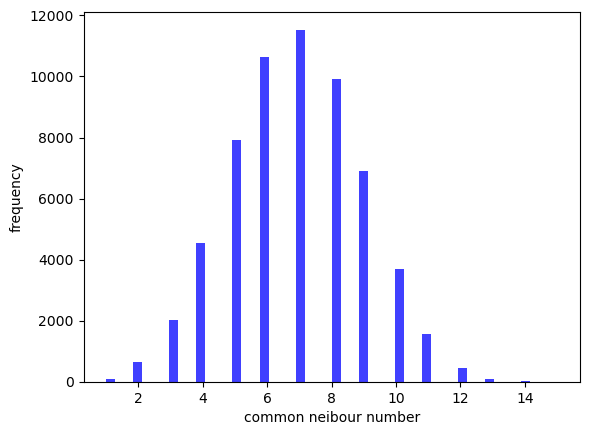

In [6]:
# # 计算平均共同k近邻数量
# def calculate_average_common_neighbors(indices1, indices2):
#     total_common_neighbors = 0

#     # 对每个点计算共同邻居的数量
#     for i in range(indices1.shape[0]):
#         common_neighbors = len(set(indices1[i]) & set(indices2[i]))
#         total_common_neighbors += common_neighbors

#     # 计算平均值
#     average_common_neighbors = total_common_neighbors / indices1.shape[0]
#     return average_common_neighbors
common_n = []
def calculate_average_common_neighbor_ratio(indices1, indices2):
    total_ratio = 0
    count = 0

    # 对每个点计算共同邻居占比
    for i in range(indices1.shape[0]):
        common_neighbors = set(indices1[i]) & set(indices2[i])
        all_neighbors = set(indices1[i]) | set(indices2[i])
        common_n.append(len(common_neighbors))
        if all_neighbors:
            ratio = len(common_neighbors) / len(all_neighbors)
            total_ratio += ratio
            count += 1

    # 计算平均占比，避免除以零
    if count > 0:
        average_ratio = total_ratio / count
    else:
        average_ratio = 0

    return average_ratio,common_n

# 计算结果
average_common_neighbors,common_n = calculate_average_common_neighbor_ratio(indices, indices2)
# average_common_neighbors
print("average_common_neighbors",average_common_neighbors)

import matplotlib.pyplot as plt
import numpy as np
# 绘制 common_nn_counts 的分布柱状图
plt.hist(common_n, bins=50, alpha=0.75, color='blue')
plt.xlabel('common neibour number')
plt.ylabel('frequency')
plt.show()



In [12]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
def eval_clustering(X, range_n_clusters):
    """
        silhouette_score:
            Higher values indicate that the clusters are tighter and well separated
        Calinski-Harabasz: 
            Higher values indicate small internal differences and large internal differences,
        Davies-Bouldin: Lower values indicate better clustering
    """

    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []

    for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # 轮廓系数
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)

        # Calinski-Harabasz指数
        ch_score = calinski_harabasz_score(X, cluster_labels)
        calinski_harabasz_scores.append(ch_score)

        # Davies-Bouldin指数
        db_score = davies_bouldin_score(X, cluster_labels)
        davies_bouldin_scores.append(db_score)
        print("{} clusters silhouette_avg is {}, Calinski-Harabasz is{} and Davies-Bouldin is{}".format(n_clusters, silhouette_avg,ch_score,db_score ))
    
    return silhouette_scores,calinski_harabasz_scores,davies_bouldin_scores

In [13]:
clusterer = KMeans(n_clusters=10, random_state=10)
ref_cluster_labels = clusterer.fit_predict(ref_data)
ref_c = clusterer.cluster_centers_
tarClusterer = KMeans(n_clusters=10, random_state=10)
tar_cluster_labels = tarClusterer.fit_predict(tar_data)
tar_c = tarClusterer.cluster_centers_

ref_c_pred = ref_data_provider.get_pred(epoch, ref_c)
tar_c_pred = tar_data_provider.get_pred(epoch, tar_c)

100%|██████████| 1/1 [00:00<00:00, 5090.17it/s]


In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# 计算余弦相似度矩阵
cosine_sim_matrix = cosine_similarity(ref_c_pred, tar_c_pred)

# 对于ref_c_pred中的每一个中心，找到与之最相似的tar_c_pred中的中心
matches = np.argmax(cosine_sim_matrix, axis=1)
tar_c = tar_c[matches]

diff_ref = ref_data[:, np.newaxis, :] - ref_c[np.newaxis, :, :]
distance_to_c_ref = np.sqrt(np.sum(diff_ref ** 2, axis=2))
diff_tar = tar_data[:, np.newaxis, :] - tar_c[np.newaxis, :, :]
distance_to_c_tar = np.sqrt(np.sum(diff_tar ** 2, axis=2))

In [18]:
"""
distance to center consistency
"""
from scipy.stats import spearmanr
def consistency_score(distance_to_c_ref, distance_to_c_tar):
    scores = []
    for ref_distances, tar_distances in zip(distance_to_c_ref, distance_to_c_tar):
        # 对每个样本到各个中心点的距离进行排序
        ref_sorted_indices = np.argsort(ref_distances)
        tar_sorted_indices = np.argsort(tar_distances)
        # ref_sorted_indices = ref_sorted_indices[:3]
        # tar_sorted_indices = tar_sorted_indices[:3]
       # 检查最近距离是否不一致
        if ref_sorted_indices[0] != tar_sorted_indices[0]:
            # 如果最近的距离不一致，则给予显著的负得分
            scores.append(-1)
        else:
            # 否则，计算Spearman等级相关系数
            coef, _ = spearmanr(ref_sorted_indices, tar_sorted_indices)
            scores.append(coef)
    
    return np.array(scores)

scores = consistency_score(distance_to_c_ref, distance_to_c_tar)

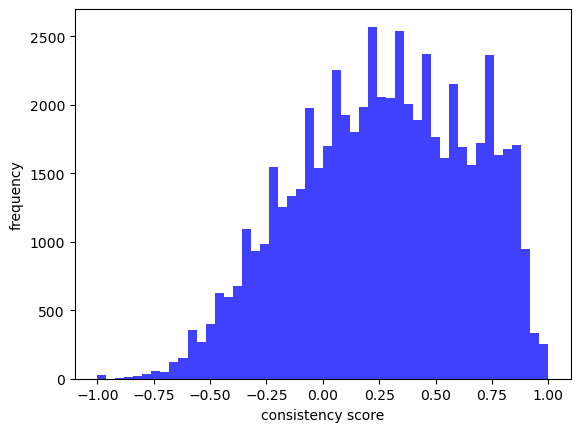

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制 scores 的分布柱状图
plt.hist(scores, bins=50, alpha=0.75, color='blue')
plt.xlabel('consistency score')
plt.ylabel('frequency')
plt.show()


In [17]:
indicates = np.where(scores > 0)[0]
print(len(indicates))


46185


In [9]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(ref_data)
_, ref_nn_indices = nbrs.kneighbors(ref_data)
nbrs = NearestNeighbors(n_neighbors=15, algorithm='auto').fit(tar_data)
_, tar_nn_indices = nbrs.kneighbors(tar_data)
common_nn_counts = np.zeros(len(ref_nn_indices), dtype=int)
for i in range(len(ref_nn_indices)):
    common_nn_counts[i] = np.intersect1d(ref_nn_indices[i], tar_nn_indices[i]).size

In [53]:
len(indicates[0])

88

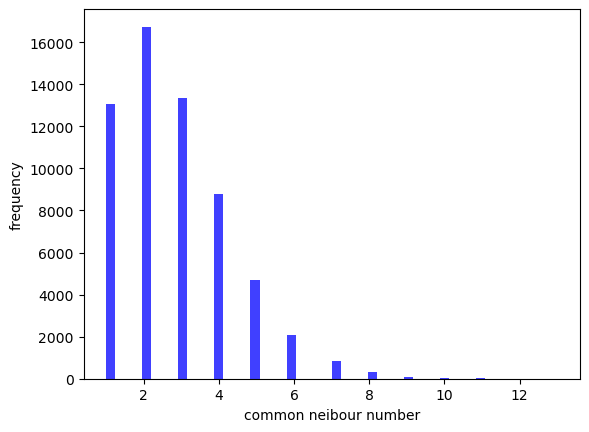

In [60]:
import matplotlib.pyplot as plt
import numpy as np
common_nn_counts[indicates[0]]
# 绘制 common_nn_counts 的分布柱状图
plt.hist(common_nn_counts, bins=50, alpha=0.75, color='blue')
plt.xlabel('common neibour number')
plt.ylabel('frequency')
plt.show()


In [61]:
common_nn_counts_rate = common_nn_counts/15
topologyScore = scores + common_nn_counts_rate
aligned = np.where(topologyScore > 0.5)[0]
print("aligned number", len(aligned))
# Unaligned mask is simply the inverse of the aligned mask
aligned_mask = topologyScore > 0.5
unaligned_mask = ~aligned_mask

aligned number 39561


In [64]:
from Transformation.transform import TransformationTrainer
Transformation_Trainer = TransformationTrainer(ref_data,tar_data,ref_data_provider,tar_data_provider,epoch,epoch,'cuda:0',15)

100%|██████████| 300/300 [00:00<00:00, 8105.35it/s]


In [43]:
aligned_ref_pred_Res = ref_pred_Res[aligned]
aligned_tar_pred_Res = tar_pred_Res[aligned]

In [57]:
indicates = np.where(ref_pred_Res != tar_pred_Res)

In [58]:
len(indicates[0])

605

In [26]:
trans_model,tar_data_mapped,tar_proxy_mapped,ref_reconstructed  = Transformation_Trainer.transformation_train(num_epochs=1000)

diff is 605
Number of matching elements: 6055
Number of matching elements: 6055
Number of matching elements: 6190
Number of matching elements: 5736
Number of matching elements: 5736
Number of matching elements: 5851
Number of matching elements: 6190
Number of matching elements: 5736
Number of matching elements: 6055
Number of matching elements: 5648
Number of matching elements: 6310
Number of matching elements: 5648
Number of matching elements: 6310
Number of matching elements: 6055
Number of matching elements: 5736
Number of matching elements: 5736
Number of matching elements: 5736
Number of matching elements: 6055
Number of matching elements: 6018
Number of matching elements: 5736
Number of matching elements: 6190
Number of matching elements: 5736
Number of matching elements: 5648
Number of matching elements: 5648
Number of matching elements: 6055
Number of matching elements: 6190
Number of matching elements: 5736
Number of matching elements: 6310
Number of matching elements: 5851
Nu

In [29]:
from eval.evaluate import *
def eval_inv_train(epoch,train_data, data_provider,n_data_provider, embedding):
        pred = data_provider.get_pred(epoch, train_data).argmax(axis=1)
        new_pred = n_data_provider.get_pred(epoch, embedding).argmax(axis=1)

        val = evaluate_inv_accu(pred, new_pred)
        # val_error = evaluate_vis_error(pred, new_pred)
   
        print("#train# PPR: {:.2f} in epoch {:d}".format(val, epoch))
        return val

eval_inv_train(epoch, tar_data, tar_data_provider, ref_data_provider, tar_data_mapped)

100%|██████████| 300/300 [00:00<00:00, 8068.09it/s]

#train# PPR: 1.00 in epoch 10


0.9973166666666666

In [30]:
eval_inv_train(10, ref_data, ref_data_provider, tar_data_provider, ref_reconstructed)

100%|██████████| 300/300 [00:00<00:00, 7998.55it/s]

#train# PPR: 1.00 in epoch 10


0.9984833333333333